# Preprocessing

## This notebook contains performs the following tasks:
* Pre-cleaning:
    * Convert to lower
    * Eliminate URL, mails and phone numbers tags 
    * Replace troublemaker puntuation elements with spaces to help the tokenization
    * Clean unicode characters
    * Replace dot between words without messing with valid words
* Group text info in two groups:
    * Group 1 - Offer info: title, requirements, benefits
    * Group 2 - Company info: company_profile, description 
* Tokenize:
    * Using NLP we tokenize the previous step's information
    * Filter the punctuation tokens, spaces, stop words digits, numbers and everything that resembles a digit, url and emails
    * Convert text to singular
* Build vocab
    * Create bag of words dictionary with the lemme info, clean text, company and offer info to give insights and refine cleaning tasks 
    * Apply tokenized and lemmatize info the text columns of the dataset
* Generate vectors


<img src="../img/bow.png" width="900"> 

# Import libraries

In [1]:
import pandas as pd 
import numpy as np
import re
import itertools
import spacy
import string
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline 
from spacy.lemmatizer import Lemmatizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Set params

## Set spacy params:
   * Load language in spacy
   * Set the np max length 

In [2]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
nlp.max_length = 33000000 

## Set the text columns to clean

In [3]:
company = ['company_profile', 'description']
offer = ['title', 'requirements', 'benefits']
columns = [*company, *offer] 

# Declare functions

## Data pre-cleaning 

In [212]:
def clean_url(str_text_raw):
    '''This function eliminate a string URL in a given text'''
    str_text = re.sub('url_\S+', '', str_text_raw)
    str_text = re.sub('email_\S+', '', str_text)
    str_text = re.sub('phone_\S+', '', str_text)
    return(re.sub('http[s]?://\S+', '', str_text))
    
def clean_punctuation(str_text_raw):
    '''This function replace some of the troublemaker puntuation elements in a given text'''
    return(re.sub('[$\(\)/|{|\}#~\[\]^#;:!?¿]', ' ', str_text_raw))

def clean_unicode(str_text_raw):
    '''This function eliminate non-unicode text'''
    str_text = re.sub('&amp;', '', str_text_raw)
    return(re.sub(r'[^\x00-\x7F]+',' ', str_text))
                      
def clean_dot_words(str_text_raw):
    '''This function replace the dots between words'''
    return(re.sub(r'(\w+)\.+(\w+)', r'\1 \2',str_text_raw))

def clean_text(str_text_raw):
    '''This function clean a given '''
    str_text = str_text_raw.lower()
    str_text = clean_dot_words(clean_punctuation(clean_unicode(clean_url(str_text))))
    return(str_text)

## Tokenization and lemmatization

In [228]:
tokens_to_drop=['+']

def string_to_token(string, str_pickle = None):
    '''
    This function takes a sentence and returns the list of tokens and all their information
    * Text: The original text of the lexeme.
    * Lemme: Lexeme.
    * Orth: The hash value of the lexeme.
    * is alpha: Does the lexeme consist of alphabetic characters?
    * is digit: Does the lexeme consist of digits?
    * is_title: Is the token in titlecase? 
    * is_punct: Is the token punctuation?
    * is_space: Does the token consist of whitespace characters?
    * is_stop: Is the token part of a “stop list”?
    * is_digit: Does the token consist of digits?
    * lang: Language of the token
    * tag: Fine-grained part-of-speech. The complete list is in: 
    https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html, also using: spacy.explain("RB")
    * pos: Coarse-grained part-of-speech.
    * has_vector: A boolean value indicating whether a word vector is associated with the token.
    * vector_norm: The L2 norm of the token’s vector representation.
    * is_ovv: '''
    doc = nlp(string)
    l_token = [[token.text, token.lemma_, token.orth, token.is_alpha, token.is_digit, token.is_title, token.lang_, 
        token.tag_, token.pos_, token.has_vector, token.vector_norm, token.is_oov]
        for token in doc if not token.is_punct | token.is_space | token.is_stop | token.is_digit | token.like_url 
               | token.like_num | token.like_email & token.is_oov]
    pd_token = pd.DataFrame(l_token, columns=['text', 'lemme', 'orth', 'is_alpha', 'is_digit', 'is_title', 'language',
                                          'tag', 'part_of_speech', 'has_vector', 'vector_norm', 'is_oov'])
    #drop problematic tokens
    pd_token = pd_token[~pd_token['text'].isin(tokens_to_drop)]
    #Convert plural text to singular
    pd_token['text_to_singular'] = np.where(pd_token['tag'].isin(['NNPS', 'NNS']), pd_token['lemme'], pd_token['text'])
    if(str_pickle!=None):
        pd_token.to_pickle(f'../data/pickles/{str_pickle}.pkl')
    del l_token
    return(pd_token)

def apply_cleaning(string):
    '''
    This function takes a sentence and returns a clean text
    '''
    doc = nlp(clean_text(string))
    l_token = [token.text for token in doc if not token.is_punct | token.is_space | token.is_stop | 
               token.is_digit | token.like_url | token.like_num | token.like_email & token.is_oov]
    return ' '.join(l_token)

def apply_lemma(string):
    '''
    This function takes a sentence and returns a clean text
    '''
    doc = nlp(clean_text(string))
    l_token = [token.lemma_ for token in doc if not token.is_punct | token.is_space | token.is_stop | 
               token.is_digit | token.like_url | token.like_num | token.like_email & token.is_oov]
    return ' '.join(l_token)

def list_to_bow(l_words):
    '''
    This function takes a list of words and create the bag of words ordered by desc order
    '''
    cv = CountVectorizer(l_words)
    # show resulting vocabulary; the numbers are not counts, they are the position in the sparse vector.
    count_vector=cv.fit_transform(l_words)
    word_freq = Counter(l_words)
    print(f'Bag of words size: {count_vector.shape}\nUnique words size: {len(word_freq)}')
    dict_word_freq = dict(word_freq.most_common())
    return(dict_word_freq)

# Load CVS file

In [179]:
df_data_raw = pd.read_csv('../data/fake_job_postings.csv')

# Import text info

In [180]:
df_data_raw[company] = df_data_raw[company].fillna('')
df_data_raw[offer] = df_data_raw[offer].fillna('')
df_data_raw.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Group text info and clean data

In [190]:
df_data = pd.DataFrame(df_data_raw[['job_id', 'fraudulent']])
for c in columns:
    df_data[c] = df_data_raw[c].apply(lambda row: clean_text(row))
df_data['company'] = df_data_raw[company].apply(lambda x: ' '.join(x), axis=1)
df_data['offer'] = df_data_raw[offer].apply(lambda x: ' '.join(x), axis=1)
df_data.head()

,job_id,fraudulent,company_profile,description,title,requirements,benefits,company,offer
0,1,0,"we're food52, and we've created a groundbreaki...","food52, a fast-growing, james beard award-winn...",marketing intern,experience with content management systems a m...,,"We're Food52, and we've created a groundbreaki...",Marketing Intern Experience with content manag...
1,2,0,"90 seconds, the worlds cloud video production ...",organised - focused - vibrant - awesome!do you...,customer service - cloud video production,what we expect from you:your key responsibilit...,what you will get from usthrough being part of...,"90 Seconds, the worlds Cloud Video Production ...",Customer Service - Cloud Video Production What...
2,3,0,valor services provides workforce solutions th...,"our client, located in houston, is actively se...",commissioning machinery assistant (cma),implement pre-commissioning and commissioning ...,,Valor Services provides Workforce Solutions th...,Commissioning Machinery Assistant (CMA) Implem...
3,4,0,our passion for improving quality of life thro...,the company: esri environmental systems rese...,account executive - washington dc,"education: bachelor s or master s in gis, busi...",our culture is anything but corporate we have ...,Our passion for improving quality of life thro...,Account Executive - Washington DC EDUCATION: B...
4,5,0,spotsource solutions llc is a global human cap...,job title: itemization review managerlocation:...,bill review manager,qualifications:rn license in the state of texa...,full benefits offered,SpotSource Solutions LLC is a Global Human Cap...,Bill Review Manager QUALIFICATIONS:RN license ...


## Load the unified text in the spacy nlp, tokenize rows and stores it in pickles . CAUTION: This is a very consumming memory process, with average wall time: ~ 20 min. If you don't want to wait please go to the next step

In [182]:
%%time
for column in columns:    
    str_bow_column = ' '.join(df_data[column])
    pd_token = string_to_token(str_bow_column, f'token_{column}')
    print(f'Length of {column} column: {len(str_bow_column)}')
    print(f'Number of tokens created: {pd_token.shape[0]}\n')

Length of company_profile column: 10803421
Number of tokens created: 951405

Length of description column: 21121576
Number of tokens created: 1873825

Length of title column: 528000
Number of tokens created: 61350

Length of requirements column: 10397543
Number of tokens created: 932962

Length of benefits column: 3634448
Number of tokens created: 325234

Wall time: 21min 41s


## Load the pickles into Dataframe

In [184]:
%%time
pd_token = pd.DataFrame(columns=['column', 'text', 'lemme', 'orth', 'is_alpha', 'is_digit', 'is_title', 'language', 'tag', 
                                 'part_of_speech', 'has_vector', 'vector_norm', 'is_oov', 'text_to_singular'])
for column in columns:
    pd_temp = pd.read_pickle(f'../data/pickles/token_{column}.pkl')
    pd_temp['column'] = column
    print(f'Loading {column} info with {pd_temp.shape[0]} rows')
    pd_token = pd.concat([pd_token, pd_temp])
print(f'Total rows loaded: {pd_token.shape[0]}')

Loading company_profile info with 951405 rows
Loading description info with 1873825 rows
Loading title info with 61350 rows
Loading requirements info with 932962 rows
Loading benefits info with 325234 rows
Total rows loaded: 4144776
Wall time: 21.4 s


# Bag of words

## Create bag of words with lemme ordered by descending frequency

Bag of words size: (4144776, 92558)
Unique words size: 110391


<function matplotlib.pyplot.show(*args, **kw)>

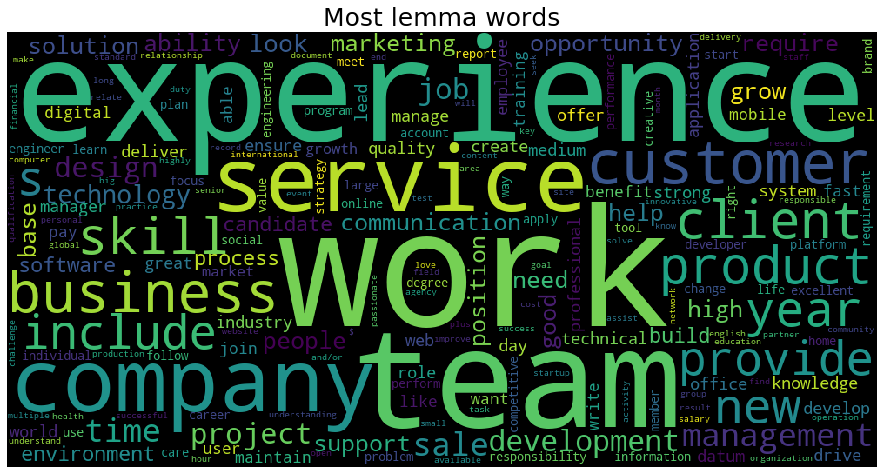

In [186]:
dict_word_freq_lemme = list_to_bow(list(pd_token['lemme']))
wordcloud = WordCloud(width = 1000, height = 500, normalize_plurals=True).generate_from_frequencies(dict_word_freq_lemme)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Most lemma words", fontsize=25)
plt.show

## Create bag of words with clean text ordered by descending frequency

Bag of words size: (4144776, 95025)
Unique words size: 113285


<function matplotlib.pyplot.show(*args, **kw)>

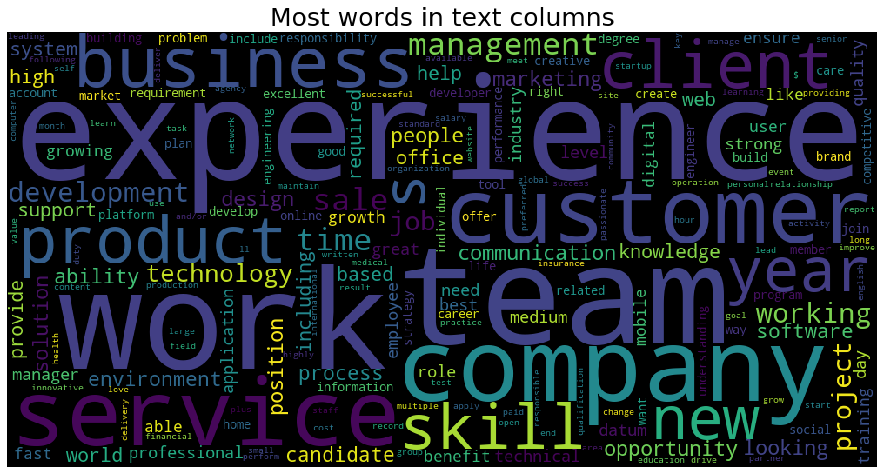

In [185]:
dict_word_freq_texts = list_to_bow(list(pd_token['text_to_singular']))
wordcloud = WordCloud(width = 1000, height = 500, normalize_plurals=True).generate_from_frequencies(dict_word_freq_texts)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Most words in text columns", fontsize=25)
plt.show

## Create bag of words with text of Company info: company_profile, description

Bag of words size: (2825230, 59121)
Unique words size: 68268


<function matplotlib.pyplot.show(*args, **kw)>

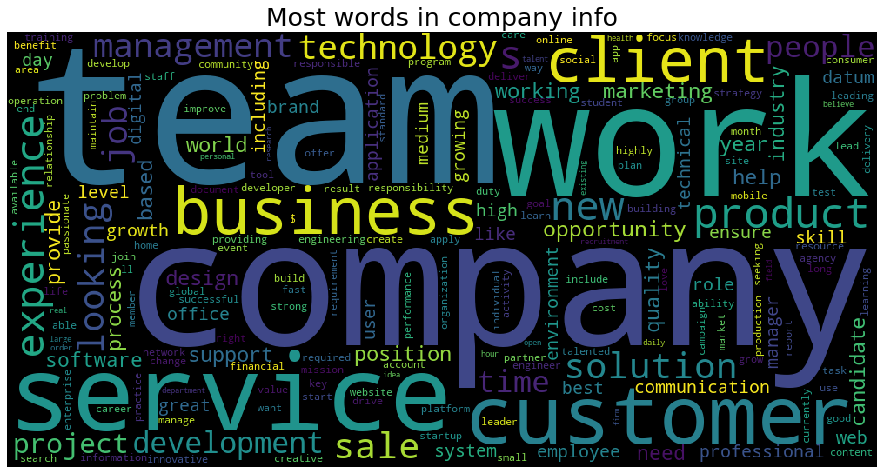

In [187]:
dict_word_freq_company = list_to_bow(list(pd_token[pd_token['column'].isin(company)]['text_to_singular']))
wordcloud = WordCloud(width = 1000, height = 500, normalize_plurals=True).generate_from_frequencies(dict_word_freq_company)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Most words in company info", fontsize=25)
plt.show

## Create bag of words with text of Offer info: title, requirements, benefits

Bag of words size: (1310501, 56788)
Unique words size: 82560


<function matplotlib.pyplot.show(*args, **kw)>

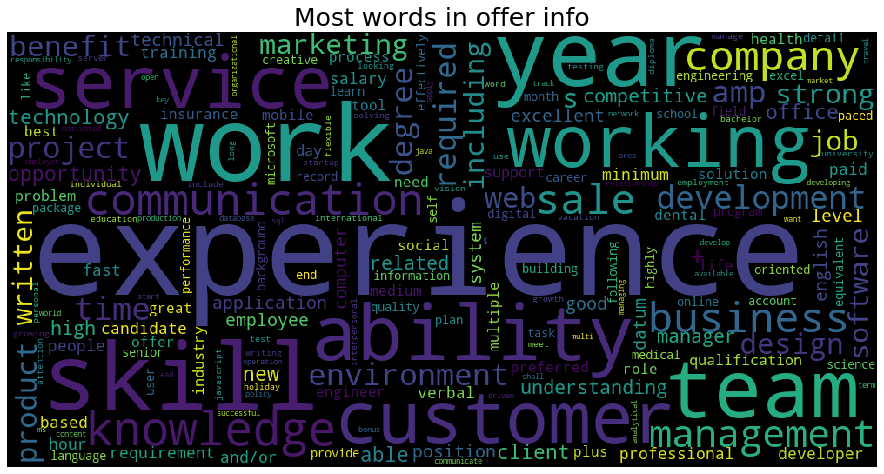

In [20]:
dict_word_freq_offer = list_to_bow(list(pd_token[pd_token['column'].isin(offer)]['text_to_singular']))
wordcloud = WordCloud(width = 1000, height = 500, normalize_plurals=True).generate_from_frequencies(dict_word_freq_offer)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Most words in offer info", fontsize=25)
plt.show

# Apply cleaned info to the dataset and store it into a pickle

In [229]:
df_data['company_clean'] = df_data['company'].apply(lambda x: apply_cleaning(x))
df_data['offer_clean']   = df_data['offer'].apply(lambda x: apply_cleaning(x))
df_data['company_lemma'] = df_data['company'].apply(lambda x: apply_lemma(x))
df_data['offer_lemma']   = df_data['offer'].apply(lambda x: apply_lemma(x))
df_data.head()

,job_id,fraudulent,company_profile,description,title,requirements,benefits,company,offer,company_text,offer_text,company_clean,offer_clean,company_lemma,offer_lemma
0,1,0,"we're food52, and we've created a groundbreaki...","food52, a fast-growing, james beard award-winn...",marketing intern,experience with content management systems a m...,,"We're Food52, and we've created a groundbreaki...",Marketing Intern Experience with content manag...,food52 created groundbreaking award winning co...,marketing intern experience content management...,food52 created groundbreaking award winning co...,marketing intern experience content management...,food52 create groundbreaking award win cooking...,market intern experience content management sy...
1,2,0,"90 seconds, the worlds cloud video production ...",organised - focused - vibrant - awesome!do you...,customer service - cloud video production,what we expect from you:your key responsibilit...,what you will get from usthrough being part of...,"90 Seconds, the worlds Cloud Video Production ...",Customer Service - Cloud Video Production What...,seconds worlds cloud video production service ...,customer service cloud video production expect...,seconds worlds cloud video production service ...,customer service cloud video production expect...,second world cloud video production service se...,customer service cloud video production expect...
2,3,0,valor services provides workforce solutions th...,"our client, located in houston, is actively se...",commissioning machinery assistant (cma),implement pre-commissioning and commissioning ...,,Valor Services provides Workforce Solutions th...,Commissioning Machinery Assistant (CMA) Implem...,valor services provides workforce solutions me...,commissioning machinery assistant cma implemen...,valor services provides workforce solutions me...,commissioning machinery assistant cma implemen...,valor services provide workforce solution meet...,commission machinery assistant cma implement p...
3,4,0,our passion for improving quality of life thro...,the company: esri environmental systems rese...,account executive - washington dc,"education: bachelor s or master s in gis, busi...",our culture is anything but corporate we have ...,Our passion for improving quality of life thro...,Account Executive - Washington DC EDUCATION: B...,passion improving quality life geography heart...,account executive washington dc education bach...,passion improving quality life geography heart...,account executive washington dc education bach...,passion improve quality life geography heart e...,account executive washington dc education bach...
4,5,0,spotsource solutions llc is a global human cap...,job title: itemization review managerlocation:...,bill review manager,qualifications:rn license in the state of texa...,full benefits offered,SpotSource Solutions LLC is a Global Human Cap...,Bill Review Manager QUALIFICATIONS:RN license ...,spotsource solutions llc global human capital ...,bill review manager qualifications rn license ...,spotsource solutions llc global human capital ...,bill review manager qualifications rn license ...,spotsource solutions llc global human capital ...,bill review manager qualification rn license s...


In [230]:
df_data.to_pickle(f'../data/pickles/clean_text_columns.pkl')

# Generate vectors

In [232]:
tfidf_company = TfidfVectorizer().fit_transform(df_data['company'])
tfidf_offer = TfidfVectorizer().fit_transform(df_data['offer'])
print(tfidf_company.shape)
print(tfidf_offer.shape)

(17880, 66343)
(17880, 59731)
